# Physics-informed neural networks (PINNs): an introductory crash-course

By Ben Moseley, 2022

This workshop builds upon my blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


## Workshop goals

By the end of this workshop, you should be able to:
- code a PINN from scratch in PyTorch
- understand the different types of scientific tasks PINNs can be used for
- understand in more detail how PINNs are trained and how to improve their convergence


## Task overview

We will be coding a PINN from scratch in PyTorch and using it solve simulation and inversion tasks related to the damped harmonic oscillator.


## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

# Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful! 

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

Here you can see an overview of the 2 dimensional space (t, mu):

<img src="excalidraw1.JPG" width="750">

## Step 1: Definition and initialization

In [110]:
### Import all what you need:
import torch
import torch.nn as nn
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 

import numpy as np

import matplotlib.pyplot as plt

import time

In [111]:
# Pseudorandom number generator:
torch.manual_seed(123)

In [47]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, w0**2            # Este mu NO se utiliza!!!!!
learning_rate =  1e-3         # learning rate
lambda1, lambda2 = 1e-3, 1e-4 # loss term hyperparameters
epochs = 20001

### Initial, training and test points generation:

#### Initial condition 1: generation of initial points:
$$ u(t=0, \mu) = 1
$$


In [48]:
#### Generation of t and mu initial points (Initial condition 1) 
point_resolution = 40

ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)],-1)
ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)

print(f"Initial condition 1: \n \t [t, mu]: \n{ic1_t_mu}")
print(f"\n Initial condition 1: \n \t u(t=0, mu) = 1: \n {ic1_scope}")
print(f"\n Shapes of [t, mu] and u(t=0, mu) = 1: \n\t{ic1_t_mu.shape}, {ic1_scope.shape}")

Initial condition 1: 
 	 [t, mu]: 
tensor([[ 0.0000,  1.0000],
        [ 0.0000,  1.2308],
        [ 0.0000,  1.4615],
        [ 0.0000,  1.6923],
        [ 0.0000,  1.9231],
        [ 0.0000,  2.1538],
        [ 0.0000,  2.3846],
        [ 0.0000,  2.6154],
        [ 0.0000,  2.8462],
        [ 0.0000,  3.0769],
        [ 0.0000,  3.3077],
        [ 0.0000,  3.5385],
        [ 0.0000,  3.7692],
        [ 0.0000,  4.0000],
        [ 0.0000,  4.2308],
        [ 0.0000,  4.4615],
        [ 0.0000,  4.6923],
        [ 0.0000,  4.9231],
        [ 0.0000,  5.1538],
        [ 0.0000,  5.3846],
        [ 0.0000,  5.6154],
        [ 0.0000,  5.8462],
        [ 0.0000,  6.0769],
        [ 0.0000,  6.3077],
        [ 0.0000,  6.5385],
        [ 0.0000,  6.7692],
        [ 0.0000,  7.0000],
        [ 0.0000,  7.2308],
        [ 0.0000,  7.4615],
        [ 0.0000,  7.6923],
        [ 0.0000,  7.9231],
        [ 0.0000,  8.1538],
        [ 0.0000,  8.3846],
        [ 0.0000,  8.6154],
        [ 0.0

#### Initial condition 2: t and mu training points generation:
$$
\dfrac{d u}{d t}(t=0, \mu) = 0~
$$

In [49]:
ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)], -1)
ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)

print(f"Initial condition 2: \n \t [t, mu]: \n{ic2_t_mu}")
print(f"\n Initial condition 2: \n \t du/dt(t=0, mu) = 0: \n\t {ic2_scope}")
print(f"\n Shapes of [t, mu] and du/dt(t=0, mu) = 0: \n\t {ic2_t_mu.shape}, {ic2_scope.shape}")

Initial condition 2: 
 	 [t, mu]: 
tensor([[ 0.0000,  1.0000],
        [ 0.0000,  1.2308],
        [ 0.0000,  1.4615],
        [ 0.0000,  1.6923],
        [ 0.0000,  1.9231],
        [ 0.0000,  2.1538],
        [ 0.0000,  2.3846],
        [ 0.0000,  2.6154],
        [ 0.0000,  2.8462],
        [ 0.0000,  3.0769],
        [ 0.0000,  3.3077],
        [ 0.0000,  3.5385],
        [ 0.0000,  3.7692],
        [ 0.0000,  4.0000],
        [ 0.0000,  4.2308],
        [ 0.0000,  4.4615],
        [ 0.0000,  4.6923],
        [ 0.0000,  4.9231],
        [ 0.0000,  5.1538],
        [ 0.0000,  5.3846],
        [ 0.0000,  5.6154],
        [ 0.0000,  5.8462],
        [ 0.0000,  6.0769],
        [ 0.0000,  6.3077],
        [ 0.0000,  6.5385],
        [ 0.0000,  6.7692],
        [ 0.0000,  7.0000],
        [ 0.0000,  7.2308],
        [ 0.0000,  7.4615],
        [ 0.0000,  7.6923],
        [ 0.0000,  7.9231],
        [ 0.0000,  8.1538],
        [ 0.0000,  8.3846],
        [ 0.0000,  8.6154],
        [ 0.0

#### Generation of physical domain training points: 

In [50]:
### Generate domain physic loss sample points:
physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

print(f" Point seed list for mesh grid domain points: \n \t {physic_in_t_mu}")
print(f"Domain training points: \n \t: {physic_domain_t_mu}")
print(f"Size of Domain training points: \n \t {physic_domain_t_mu.size()}")

 Point seed list for mesh grid domain points: 
 	 [tensor([0.0100, 0.0354, 0.0608, 0.0862, 0.1115, 0.1369, 0.1623, 0.1877, 0.2131,
        0.2385, 0.2638, 0.2892, 0.3146, 0.3400, 0.3654, 0.3908, 0.4162, 0.4415,
        0.4669, 0.4923, 0.5177, 0.5431, 0.5685, 0.5938, 0.6192, 0.6446, 0.6700,
        0.6954, 0.7208, 0.7462, 0.7715, 0.7969, 0.8223, 0.8477, 0.8731, 0.8985,
        0.9238, 0.9492, 0.9746, 1.0000], requires_grad=True), tensor([ 1.0000,  1.2308,  1.4615,  1.6923,  1.9231,  2.1538,  2.3846,  2.6154,
         2.8462,  3.0769,  3.3077,  3.5385,  3.7692,  4.0000,  4.2308,  4.4615,
         4.6923,  4.9231,  5.1538,  5.3846,  5.6154,  5.8462,  6.0769,  6.3077,
         6.5385,  6.7692,  7.0000,  7.2308,  7.4615,  7.6923,  7.9231,  8.1538,
         8.3846,  8.6154,  8.8462,  9.0769,  9.3077,  9.5385,  9.7692, 10.0000],
       requires_grad=True)]
Domain training points: 
 	: tensor([[1.0000e-02, 1.0000e+00],
        [1.0000e-02, 1.2308e+00],
        [1.0000e-02, 1.4615e+00],
       

#### Generation of testing points:

In [51]:
#### Generation of t and mu test points within the domain:
point_resolution_test = 100

# Testing points:
test_in_t_mu = [torch.linspace(0,1,point_resolution_test), torch.linspace(1,10,point_resolution_test) ]
test_domain_t_mu = torch.stack(torch.meshgrid(*test_in_t_mu, indexing='ij'), -1).view(-1, 2)

print(f"Point seed list for mesh grid test points: \n \t \n \t: {physic_domain_t_mu}")
print(f"Test points \n \t [t, mu]: \n \t {physic_domain_t_mu}")
print(f"Size of the test domain points: \n \t {test_domain_t_mu.size()}")

Point seed list for mesh grid test points: 
 	 
 	: tensor([[1.0000e-02, 1.0000e+00],
        [1.0000e-02, 1.2308e+00],
        [1.0000e-02, 1.4615e+00],
        ...,
        [1.0000e+00, 9.5385e+00],
        [1.0000e+00, 9.7692e+00],
        [1.0000e+00, 1.0000e+01]], grad_fn=<ViewBackward0>)
Test points 
 	 [t, mu]: 
 	 tensor([[1.0000e-02, 1.0000e+00],
        [1.0000e-02, 1.2308e+00],
        [1.0000e-02, 1.4615e+00],
        ...,
        [1.0000e+00, 9.5385e+00],
        [1.0000e+00, 9.7692e+00],
        [1.0000e+00, 1.0000e+01]], grad_fn=<ViewBackward0>)
Size of the test domain points: 
 	 torch.Size([10000, 2])


### Exact solution:

In [52]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [53]:
# Example to check if it works (calculation of the exact solution):
test_mu = 5
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#u_exact.view(-1,1)
#u_exact.size()
#u_exact.numel()
#u_exact.dim()
u_exact

tensor([ 1.0000,  0.9800,  0.9221,  0.8305,  0.7105,  0.5682,  0.4103,  0.2440,
         0.0762, -0.0864, -0.2375, -0.3718, -0.4847, -0.5729, -0.6339, -0.6668,
        -0.6717, -0.6497, -0.6029, -0.5346, -0.4484, -0.3487, -0.2401, -0.1273,
        -0.0150,  0.0924,  0.1908,  0.2768,  0.3476,  0.4011,  0.4360,  0.4520,
         0.4492,  0.4288,  0.3923,  0.3421,  0.2808,  0.2114,  0.1370,  0.0608,
        -0.0140, -0.0846, -0.1483, -0.2031, -0.2470, -0.2791, -0.2984, -0.3050,
        -0.2992, -0.2817, -0.2540, -0.2176, -0.1743, -0.1262, -0.0755, -0.0243,
         0.0253,  0.0715,  0.1126,  0.1472,  0.1742,  0.1930,  0.2033,  0.2049,
         0.1984,  0.1843,  0.1636,  0.1374,  0.1070,  0.0740,  0.0396,  0.0053,
        -0.0275, -0.0576, -0.0839, -0.1056, -0.1220, -0.1328, -0.1378, -0.1371,
        -0.1310, -0.1200, -0.1047, -0.0861, -0.0650, -0.0423, -0.0191,  0.0038,
         0.0254,  0.0449,  0.0616,  0.0751,  0.0849,  0.0909,  0.0930,  0.0913,
         0.0861,  0.0777,  0.0666,  0.05

In [54]:
#physic_in_t_mu[0]

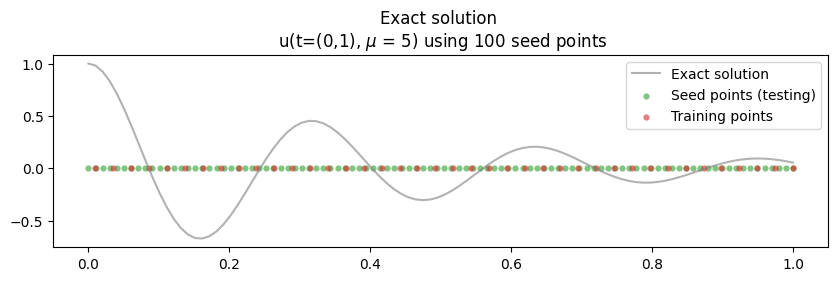

In [55]:
# Plotting the exact solution:
plt.figure(figsize=(10,2.5))
plt.plot(
        test_in_t_mu[0], 
        u_exact, 
        label="Exact solution", 
        color="tab:grey", 
        alpha=0.6)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points (testing)")
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:red",
        alpha=0.6,
        label= "Training points")

plt.title(f"Exact solution \n u(t=(0,1), $\mu$ = {test_mu}) using {point_resolution_test} seed points")
plt.legend()
plt.show()

## Step 2: Create Fully Connected Neural Network Class (FCNN):

In [56]:
### Definition of the Fully Connected Neural Network Class:
# Ben Moseley:
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Definition of the Fully Connected Neural Network Class
# Ben Moseley and added ACTIVATION FUNCTION and INITIALIZATION

class FCN_init(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation = "LeakyReLU"):#, initialization = "Xavier"):
        super().__init__()
        activation_functions = nn.ModuleDict([
                                            ["Tanh", nn.Tanh()],
                                            ["ReLU", nn.ReLU()],
                                            ["LeakyReLU", nn.LeakyReLU()],
                                            ["Sigmoid", nn.Sigmoid()],
                                            ["Softmax", nn.Softmax()],
                                            ])
      # initialization_type = nn.ModuleDict([
      #     ["Xavier", nn.init.xavier_normal_],
      #     ])
        #activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation_functions[activation]])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation_functions[activation]]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.weights_and_bias_initialization()
        #self.initialization = initialization
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

    def weights_and_bias_initialization(self):
        for module_with_layers in self.modules():
            if isinstance(module_with_layers, nn.Linear):
                #initialization_type(module_with_layers.weight)
                #nn.init.xavier_uniform_(module_with_layers.weight)
                #nn.init.constant_(module_with_layers.bias, 0)
                nn.init.kaiming_uniform_(module_with_layers.weight)
                nn.init.constant_(module_with_layers.bias, 0)

class FCN_1(nn.Module):   # inherent from nn.Module
    "Defines a standard fully-connected network in PyTorch"
    # Initialization of the neural network layers in __init__:
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()                                      
        
        # INPUT Linear function: 1x1 --> 32x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        
        # INPUT Non-linearity (activation function): 32x1-->32x1
        self.tangh = nn.Tanh()
        
        # OUTPUT Linear function: 32x1 --> 1x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    
    def forward(self, input):
        # INPUT Linear function:
        hidden = self.fc_in(input)

        # HIDDEN Non-linearity
        hidden = self.tangh(hidden)

        # OUTPUT Linear function
        output = self.fc_out(hidden)
        
        return output

## STEP 3: Instantiate the Model Class

In [57]:
model = FCN(2,1,64,4)
print(model.parameters)
print(model.state_dict())

<bound method Module.parameters of FCN(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
  )
  (fce): Linear(in_features=64, out_features=1, bias=True)
)>
OrderedDict([('fcs.0.weight', tensor([[-0.2883,  0.0234],
        [-0.3512,  0.2667],
        [-0.6025,  0.5183],
        [-0.5140, -0.5622],
        [-0.4468,  0.3202],
        [-0.2613,  0.2646],
        [-0.6001, -0.4290],
        [-0.2596, -0.1390],
        [-0.5394,  0.4630],
        [-0.1668,  0.2270],
        [ 0.5000,  0.1317],
        [ 0.1934,  0.6825],
        [-0.3189,  0.2240],
        [-0.3146,  0.5053],
        [ 0.5647, -0.6519],
  

### Checking the model using test points and a constant mu value:

In [58]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")

 Point seed list for mesh grid domain points: 
 	 tensor([[0.0000, 5.0000],
        [0.0101, 5.0000],
        [0.0202, 5.0000],
        [0.0303, 5.0000],
        [0.0404, 5.0000],
        [0.0505, 5.0000],
        [0.0606, 5.0000],
        [0.0707, 5.0000],
        [0.0808, 5.0000],
        [0.0909, 5.0000],
        [0.1010, 5.0000],
        [0.1111, 5.0000],
        [0.1212, 5.0000],
        [0.1313, 5.0000],
        [0.1414, 5.0000],
        [0.1515, 5.0000],
        [0.1616, 5.0000],
        [0.1717, 5.0000],
        [0.1818, 5.0000],
        [0.1919, 5.0000],
        [0.2020, 5.0000],
        [0.2121, 5.0000],
        [0.2222, 5.0000],
        [0.2323, 5.0000],
        [0.2424, 5.0000],
        [0.2525, 5.0000],
        [0.2626, 5.0000],
        [0.2727, 5.0000],
        [0.2828, 5.0000],
        [0.2929, 5.0000],
        [0.3030, 5.0000],
        [0.3131, 5.0000],
        [0.3232, 5.0000],
        [0.3333, 5.0000],
        [0.3434, 5.0000],
        [0.3535, 5.0000],
        [0.363

In [59]:
# NO es necesario porque se mantiene constante mu
#test_domain_t_constant_mu = torch.stack(torch.meshgrid(*test_in_t_constant_mu, indexing='ij'), -1).view(-1, 2)
#test_domain_t_constant_mu.size()
#print(f"Domain training points: \n \t: {test_domain_t_constant_mu}")

In [60]:
test_predicted = model(test_in_t_constant_mu)
test_predicted.size()

torch.Size([100, 1])

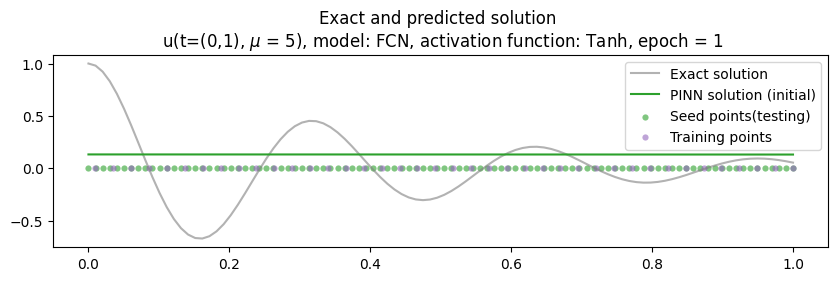

In [61]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: FCN, activation function: Tanh, epoch = 1")
plt.legend()
plt.show()

In [62]:
#test_predicted

## STEP 4: Selection of the Optimizer

In [63]:
optimiser = torch.optim.Adam(model.parameters(), lr= learning_rate)
optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

## STEP 5: Training the PINN:

Decomposition of the loss terms: 
 loss(1.0260381698608398) = loss1(0.7631644010543823) + 0.001 * loss2(8.031311153899878e-05) + 0.0001 * loss3(2628.73779296875)


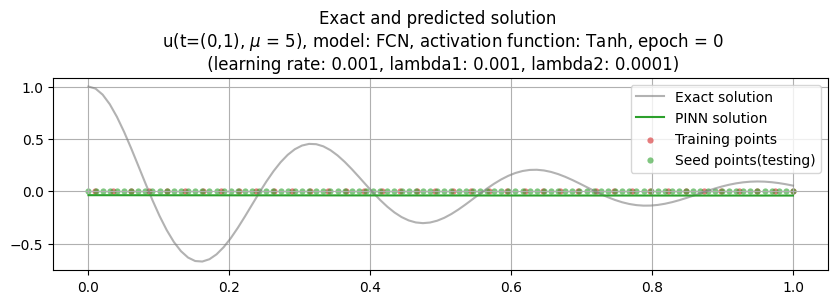

Saved the checkpoint corresponding to epoch: 0
Decomposition of the loss terms: 
 loss(0.054425060749053955) = loss1(0.0048806509003043175) + 0.001 * loss2(0.10006256401538849) + 0.0001 * loss3(494.4434814453125)


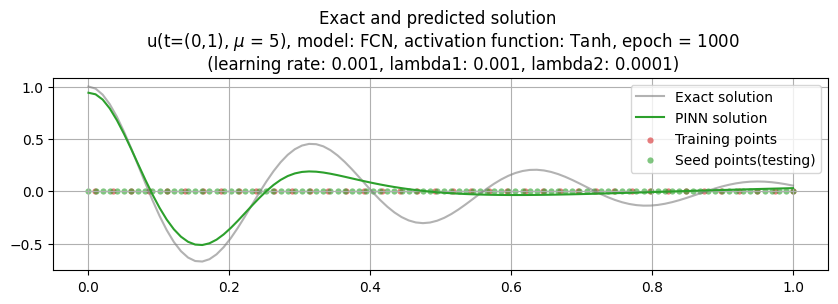

Saved the checkpoint corresponding to epoch: 1000
Decomposition of the loss terms: 
 loss(0.0251548383384943) = loss1(0.0016449198592454195) + 0.001 * loss2(0.028727203607559204) + 0.0001 * loss3(234.8119354248047)


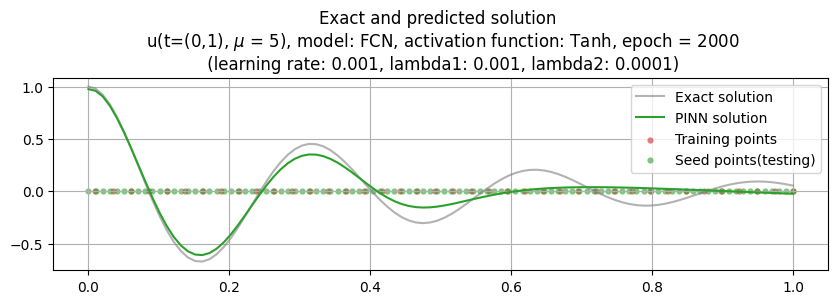

Saved the checkpoint corresponding to epoch: 2000
Training elapsed time (s): 47.029706716537476


In [64]:
epochs = 2001
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:
loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []

for i in range(epochs):
    optimiser.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= model(ic1_t_mu)
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = model(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    
    loss.backward()
    optimiser.step()
    
    
    if i%1000 == 0:
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted = model(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: FCN, activation function: Tanh, epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
        torch.save({
                    "epoch": i,
                    "model_state_dict": model.state_dict(),
                    "optimiser_state_dict": optimiser.state_dict(),
                    "loss": loss,
                   },                    
                    f"{learning_rate}_{i}.pth")
        print(f"Saved the checkpoint corresponding to epoch: {i}")
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")
        

### Load the checkpoint:

In [65]:
model = FCN(2,1,64,4) # N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYER
#pinn_gpu.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [66]:
checkpoint = torch.load(f"{learning_rate}_{i}.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
epochs = checkpoint["epoch"]
loss = checkpoint["loss"]

In [67]:
checkpoint["epoch"]

2000

## Continue training:

In [68]:
epochs

2000

In [69]:
epochs_delta = epochs + 18000

Decomposition of the loss terms: 
 loss(0.025145601481199265) = loss1(0.0016430809628218412) + 0.001 * loss2(0.028693100437521935) + 0.0001 * loss3(234.73828125)


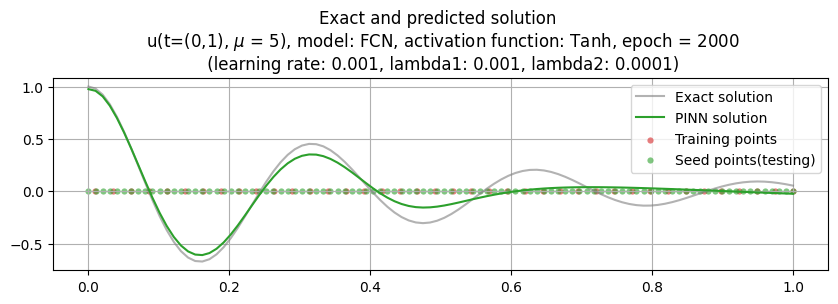

Saved the checkpoint corresponding to epoch: 2000
Decomposition of the loss terms: 
 loss(0.019518569111824036) = loss1(0.0009732080507092178) + 0.001 * loss2(0.008084617555141449) + 0.0001 * loss3(185.3727569580078)


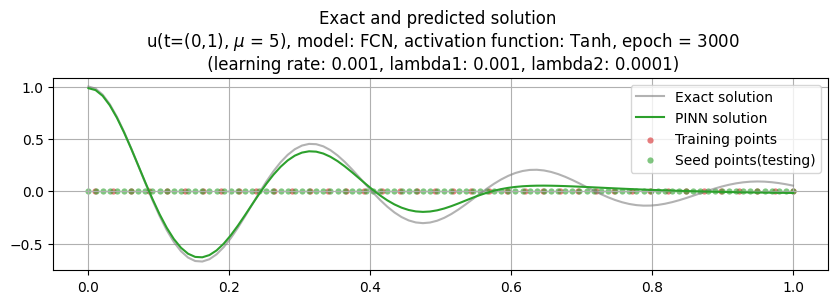

Saved the checkpoint corresponding to epoch: 3000
Decomposition of the loss terms: 
 loss(0.015110261738300323) = loss1(0.0007331204833462834) + 0.001 * loss2(0.003621629672124982) + 0.0001 * loss3(143.73519897460938)


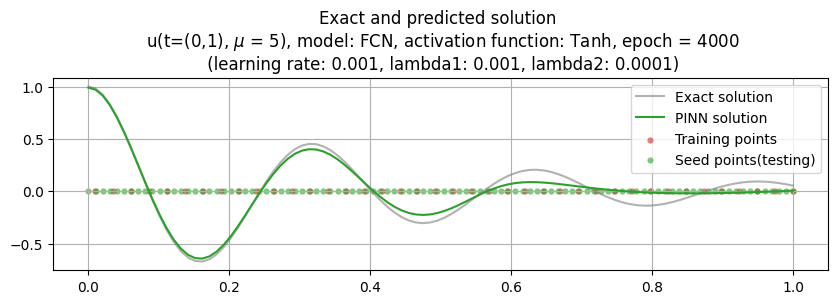

Saved the checkpoint corresponding to epoch: 4000
Decomposition of the loss terms: 
 loss(0.012761897407472134) = loss1(0.0005419980734586716) + 0.001 * loss2(0.001829046057537198) + 0.0001 * loss3(122.18070983886719)


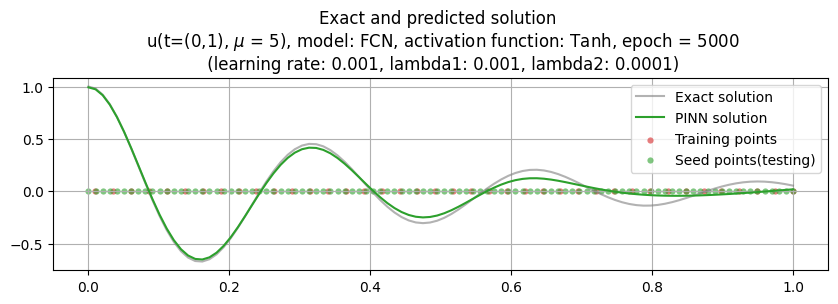

Saved the checkpoint corresponding to epoch: 5000
Decomposition of the loss terms: 
 loss(0.011452378705143929) = loss1(0.0004247535835020244) + 0.001 * loss2(0.0022330577485263348) + 0.0001 * loss3(110.2539291381836)


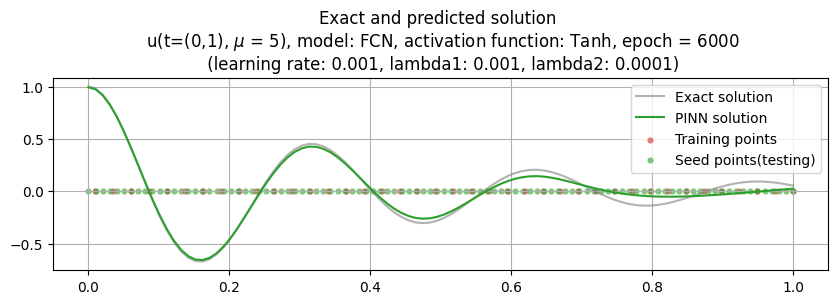

Saved the checkpoint corresponding to epoch: 6000
Decomposition of the loss terms: 
 loss(0.010440311394631863) = loss1(0.0003509136149659753) + 0.001 * loss2(0.013373017311096191) + 0.0001 * loss3(100.76024627685547)


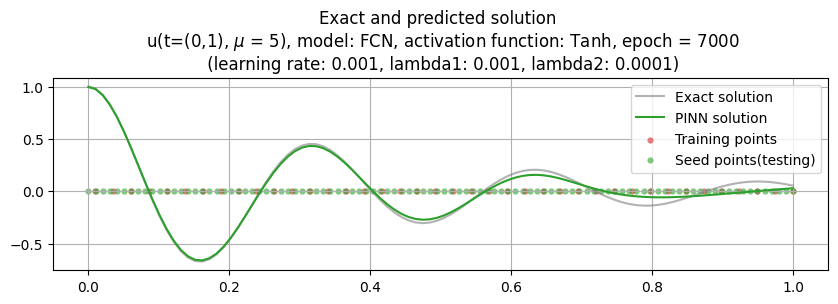

Saved the checkpoint corresponding to epoch: 7000
Decomposition of the loss terms: 
 loss(0.00937011931091547) = loss1(0.00033466503373347223) + 0.001 * loss2(0.0008787826518528163) + 0.0001 * loss3(90.34576416015625)


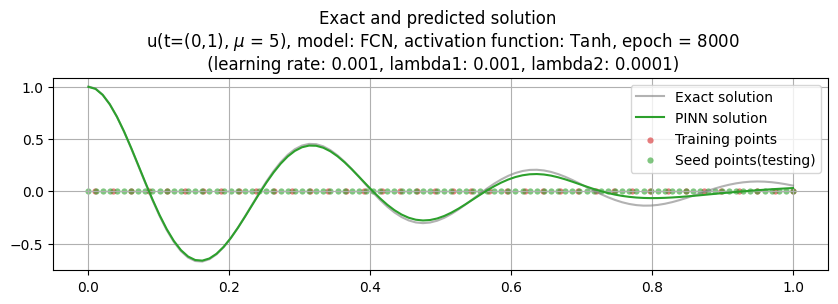

Saved the checkpoint corresponding to epoch: 8000
Decomposition of the loss terms: 
 loss(0.006394065450876951) = loss1(0.0002352047013118863) + 0.001 * loss2(0.0023434029426425695) + 0.0001 * loss3(61.5651741027832)


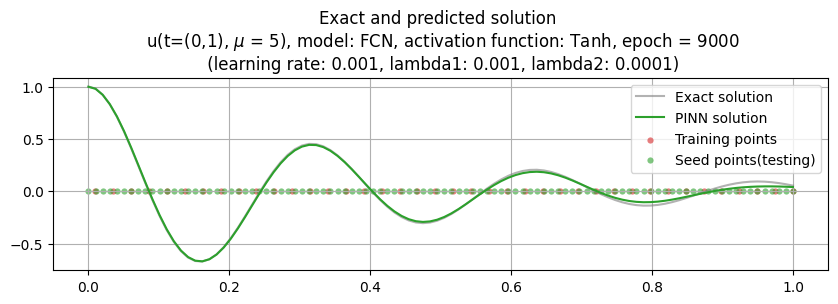

Saved the checkpoint corresponding to epoch: 9000
Decomposition of the loss terms: 
 loss(0.00394345773383975) = loss1(0.00013320273137651384) + 0.001 * loss2(0.00332053005695343) + 0.0001 * loss3(38.0693473815918)


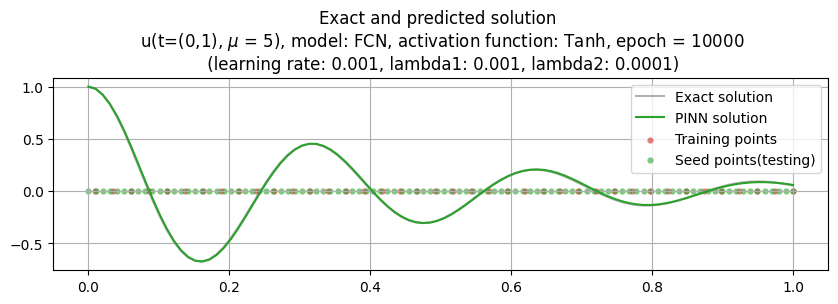

Saved the checkpoint corresponding to epoch: 10000
Decomposition of the loss terms: 
 loss(0.003142761532217264) = loss1(0.00017899215163197368) + 0.001 * loss2(0.004415505100041628) + 0.0001 * loss3(29.59354019165039)


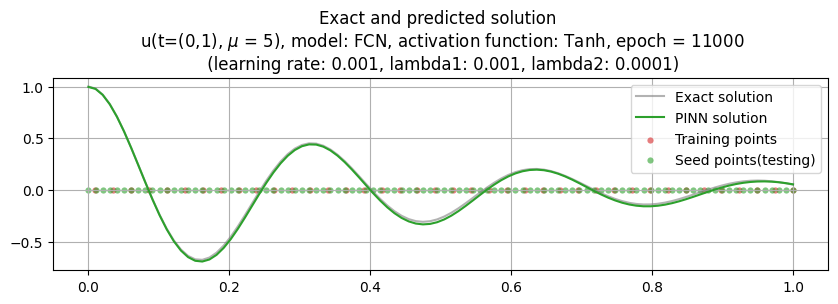

Saved the checkpoint corresponding to epoch: 11000
Decomposition of the loss terms: 
 loss(0.001961084781214595) = loss1(9.527282963972539e-05) + 0.001 * loss2(0.0007461424684152007) + 0.0001 * loss3(18.650659561157227)


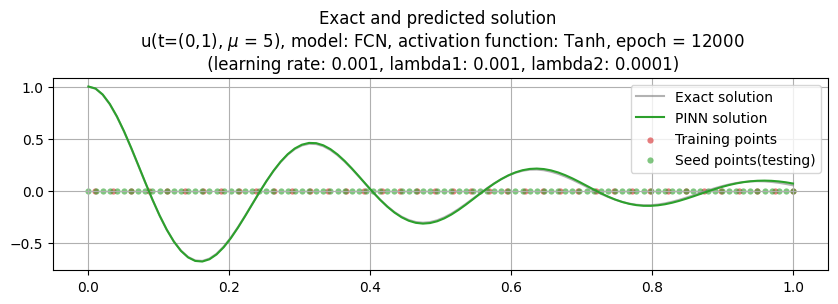

Saved the checkpoint corresponding to epoch: 12000
Decomposition of the loss terms: 
 loss(0.0013026349479332566) = loss1(6.089376984164119e-05) + 0.001 * loss2(0.0007370962994173169) + 0.0001 * loss3(12.410041809082031)


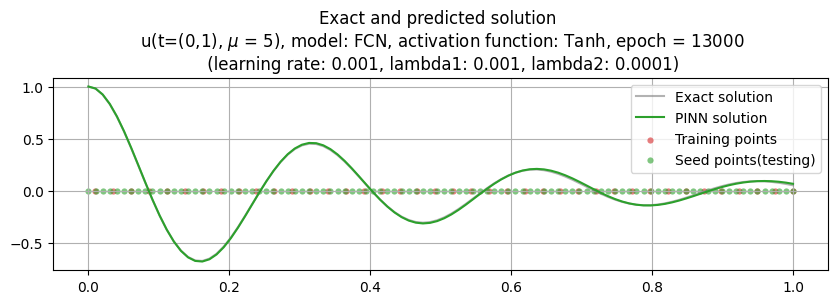

Saved the checkpoint corresponding to epoch: 13000
Decomposition of the loss terms: 
 loss(0.0008455829229205847) = loss1(3.9468657632824033e-05) + 0.001 * loss2(0.0005536858225241303) + 0.0001 * loss3(8.0556058883667)


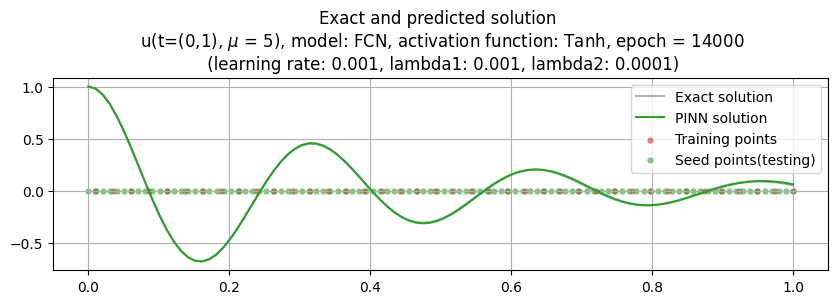

Saved the checkpoint corresponding to epoch: 14000
Decomposition of the loss terms: 
 loss(0.0009214611491188407) = loss1(3.0169467208907008e-05) + 0.001 * loss2(0.11695071309804916) + 0.0001 * loss3(7.743409633636475)


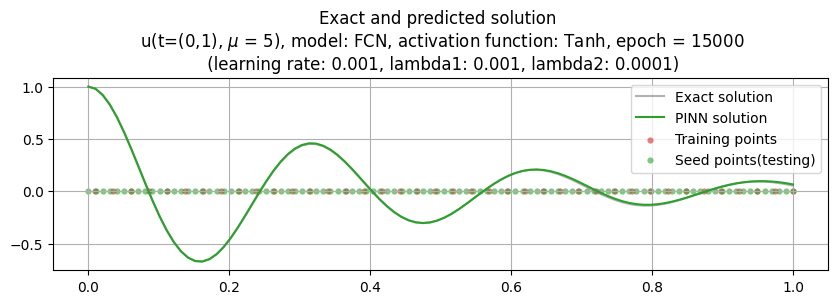

Saved the checkpoint corresponding to epoch: 15000
Decomposition of the loss terms: 
 loss(0.0004141683457419276) = loss1(1.9497998437145725e-05) + 0.001 * loss2(0.0004144395643379539) + 0.0001 * loss3(3.942559242248535)


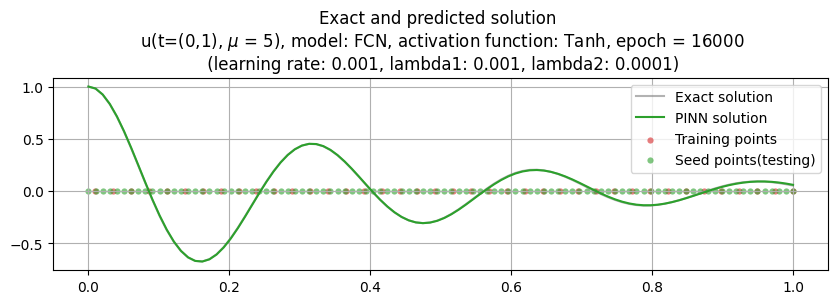

Saved the checkpoint corresponding to epoch: 16000
Decomposition of the loss terms: 
 loss(0.00030457135289907455) = loss1(1.571528446220327e-05) + 0.001 * loss2(0.00047577318036928773) + 0.0001 * loss3(2.883803129196167)


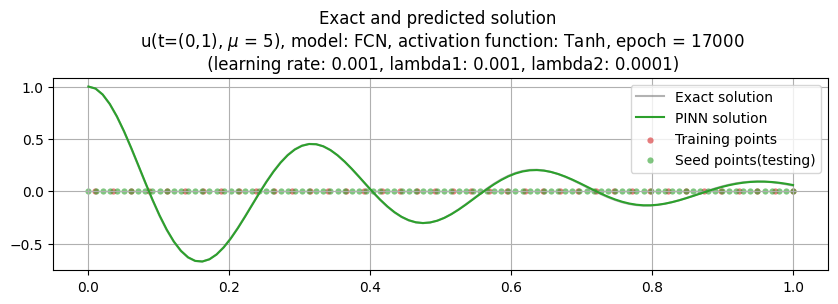

Saved the checkpoint corresponding to epoch: 17000
Decomposition of the loss terms: 
 loss(0.00023352057905867696) = loss1(1.0313894563296344e-05) + 0.001 * loss2(0.00043561571510508657) + 0.0001 * loss3(2.227710723876953)


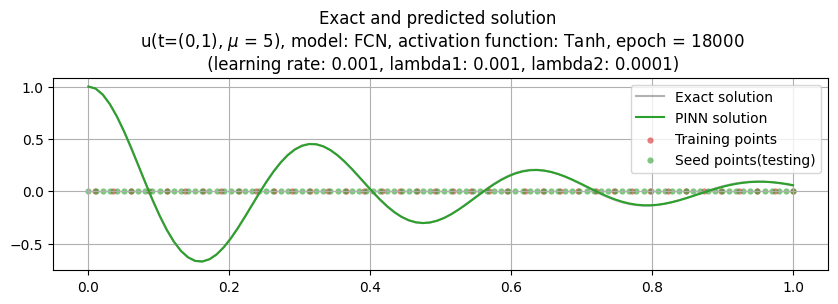

Saved the checkpoint corresponding to epoch: 18000
Decomposition of the loss terms: 
 loss(0.0004216966044623405) = loss1(1.2255317415110767e-05) + 0.001 * loss2(0.0008648104849271476) + 0.0001 * loss3(4.0857648849487305)


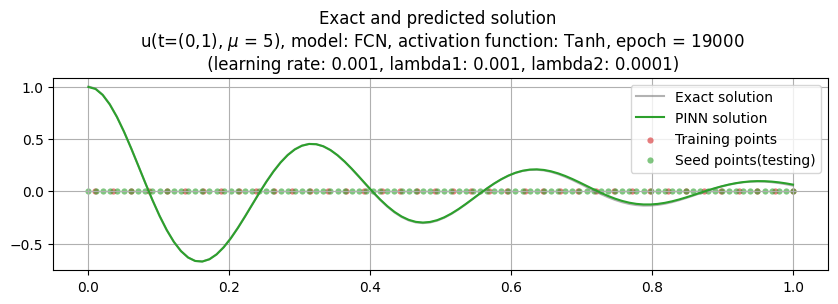

Saved the checkpoint corresponding to epoch: 19000
Decomposition of the loss terms: 
 loss(0.00015007730689831078) = loss1(5.849568424309837e-06) + 0.001 * loss2(0.0011897569056600332) + 0.0001 * loss3(1.4303797483444214)


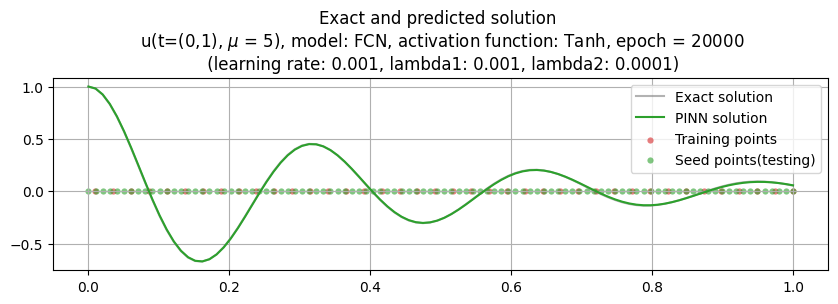

Saved the checkpoint corresponding to epoch: 20000
Training elapsed time (s): 269.82693696022034


In [70]:
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:
loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []

for i in range(epochs, epochs_delta+1): 
    optimiser.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= model(ic1_t_mu)
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = model(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    
    loss.backward()
    optimiser.step()
    
    
    if i%1000 == 0:
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted = model(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: FCN, activation function: Tanh, epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
        torch.save({
                    "epoch": i,
                    "model_state_dict": model.state_dict(),
                    "optimiser_state_dict": optimiser.state_dict(),
                    "loss": loss,
                   },                    
                    f"{learning_rate}_{i}.pth")
        print(f"Saved the checkpoint corresponding to epoch: {i}")
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")
        

### Investigation of the loss terms:

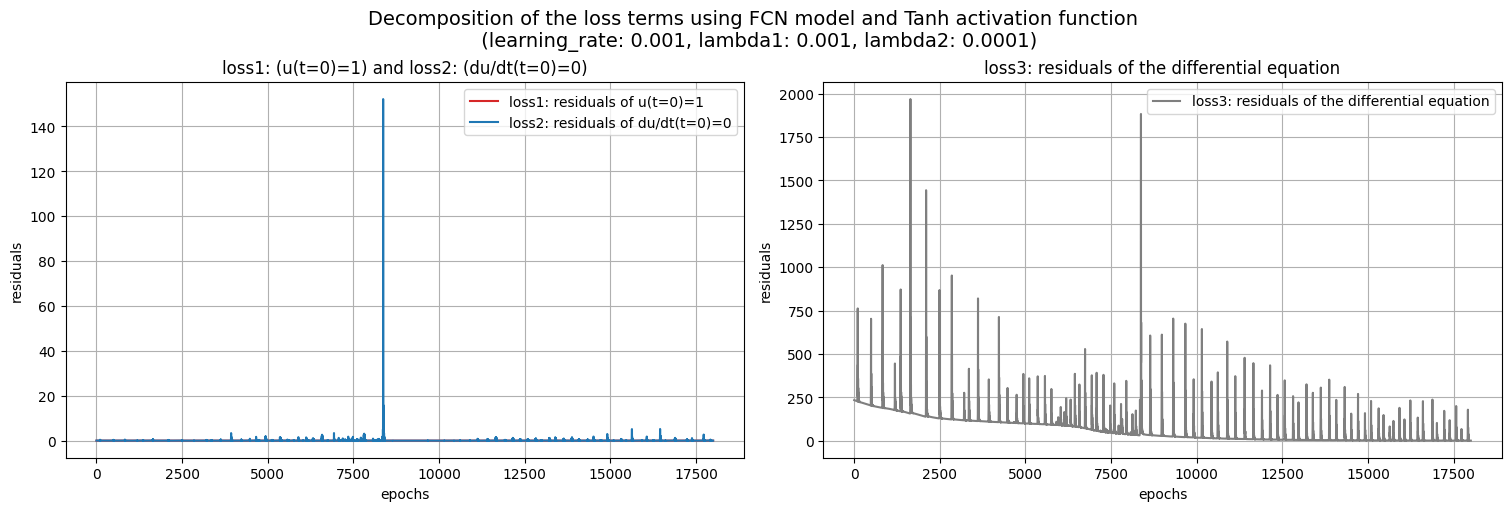

In [39]:
# plot the contribution of every loss term (loss1, loss2 and loss3)
fig, (loss1_2, loss3) = plt.subplots(1,2, layout = 'constrained', sharex = True, figsize = (15,5))
fig.suptitle(f"Decomposition of the loss terms using FCN model and Tanh activation function \n (learning_rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})", fontsize = 14)

loss1_2.plot(loss_ic1_history, label = "loss1: residuals of u(t=0)=1", color = "tab:red")
loss1_2.plot(loss_ic2_history, label = "loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
loss1_2.set_title("loss1: (u(t=0)=1) and loss2: (du/dt(t=0)=0)")
loss1_2.set_xlabel("epochs")
loss1_2.set_ylabel("residuals")
loss1_2.grid()
loss1_2.legend()

loss3.plot(loss_differential_equation_history, label= "loss3: residuals of the differential equation", color = "tab:grey")
loss3.set_title("loss3: residuals of the differential equation")
loss3.set_xlabel("epochs")
loss3.set_ylabel("residuals")
loss3.legend()
loss3.grid()

### Inference:

In [30]:
test_mu = 10
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size()

torch.Size([100, 2])

In [31]:
test_predicted = model(test_in_t_constant_mu)

In [32]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])

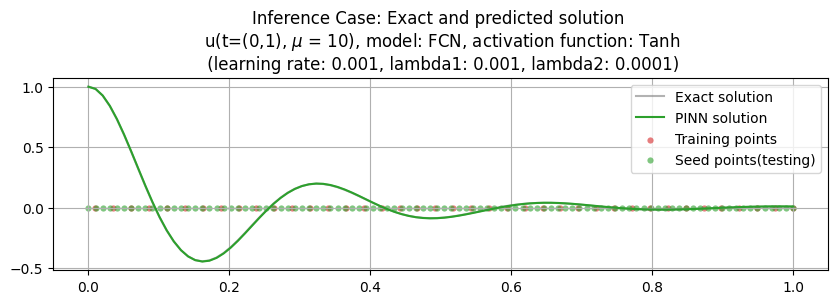

In [34]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach().numpy(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_in_t_mu[0], 
            torch.zeros_like(test_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Seed points(testing)")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: FCN, activation function: Tanh \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
plt.grid()
plt.legend()
plt.show()

### Training using a different initialization & activation function: 

In [71]:
activation_func = "LeakyReLU"
model_init = FCN_init(2,1,64,4, activation= activation_func)
model_init.parameters

<bound method Module.parameters of FCN_init(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fce): Linear(in_features=64, out_features=1, bias=True)
)>

In [72]:
#plt.imshow(model_init.state_dict()["fcs.0.weight"])

In [73]:
print(model_init.parameters)
print(model_init.state_dict().keys())

<bound method Module.parameters of FCN_init(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fce): Linear(in_features=64, out_features=1, bias=True)
)>
odict_keys(['fcs.0.weight', 'fcs.0.bias', 'fch.0.0.weight', 'fch.0.0.bias', 'fch.1.0.weight', 'fch.1.0.bias', 'fch.2.0.weight', 'fch.2.0.bias', 'fce.weight', 'fce.bias'])


In [74]:
test_predicted_init = model_init(test_in_t_constant_mu)

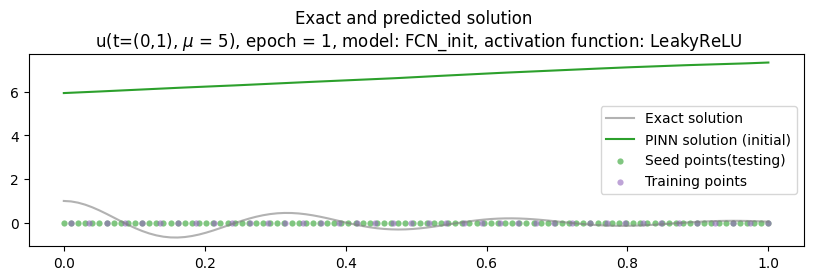

In [75]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted_init[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = 1, model: FCN_init, activation function: {activation_func}")
plt.legend()
plt.show()

### Check for a fixed value f mu:

In [76]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
#print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")b

In [77]:
test_predicted_init = model_init(test_in_t_constant_mu)
#print(test_predicted)

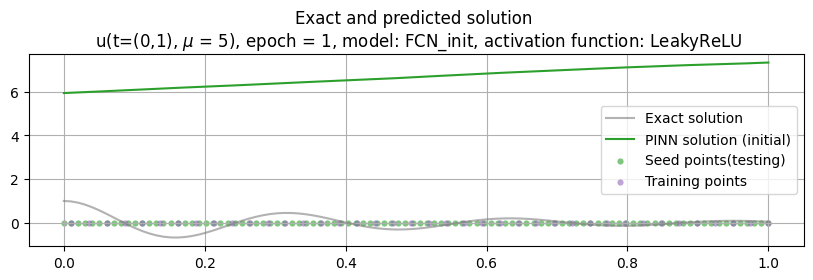

In [78]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted_init[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = 1, model: FCN_init, activation function: {activation_func}")
plt.grid()
plt.legend()
plt.show()

In [79]:
ic1_t_mu
physic_domain_t_mu
loss_ic1

tensor(5.8496e-06, grad_fn=<MeanBackward0>)

Decomposition of the loss terms: 
 loss(1050.9398193359375) = loss1(40.53205108642578) + 0.001 * loss2(2.0076231956481934) + 0.0001 * loss3(10104058.0)


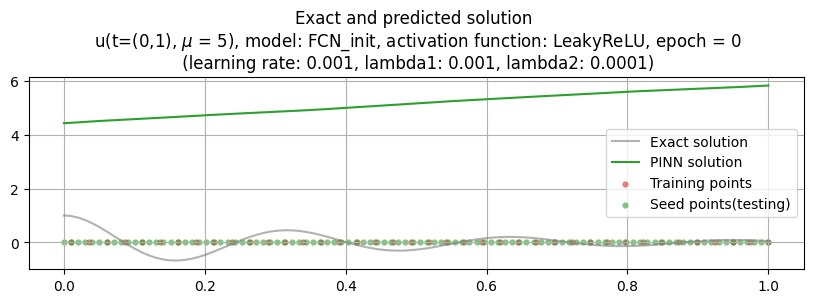

Decomposition of the loss terms: 
 loss(0.30321940779685974) = loss1(0.10943879187107086) + 0.001 * loss2(60.92170333862305) + 0.0001 * loss3(1328.589111328125)


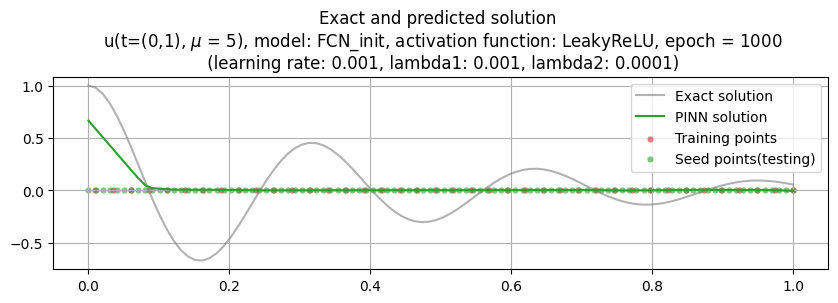

Decomposition of the loss terms: 
 loss(0.29367297887802124) = loss1(0.08646070957183838) + 0.001 * loss2(89.98178100585938) + 0.0001 * loss3(1172.304931640625)


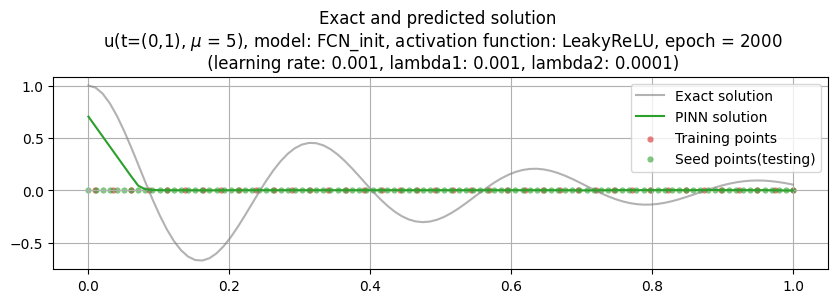

Decomposition of the loss terms: 
 loss(0.293935626745224) = loss1(0.08743422478437424) + 0.001 * loss2(89.91590881347656) + 0.0001 * loss3(1165.85498046875)


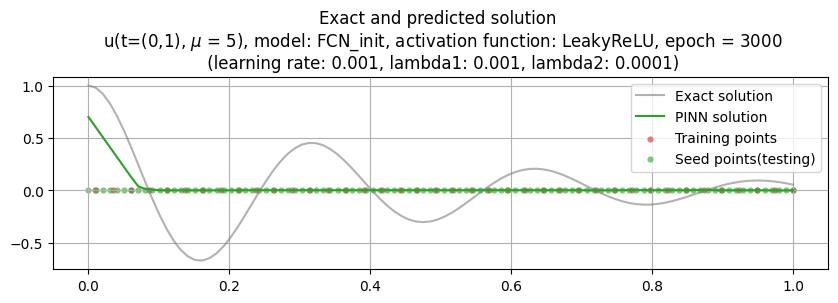

Decomposition of the loss terms: 
 loss(0.2981269061565399) = loss1(0.07280147820711136) + 0.001 * loss2(89.02203369140625) + 0.0001 * loss3(1363.033935546875)


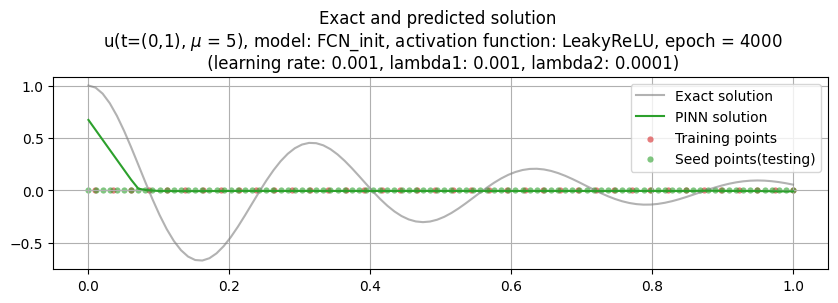

Decomposition of the loss terms: 
 loss(0.29608261585235596) = loss1(0.07803986966609955) + 0.001 * loss2(85.98368835449219) + 0.0001 * loss3(1320.5904541015625)


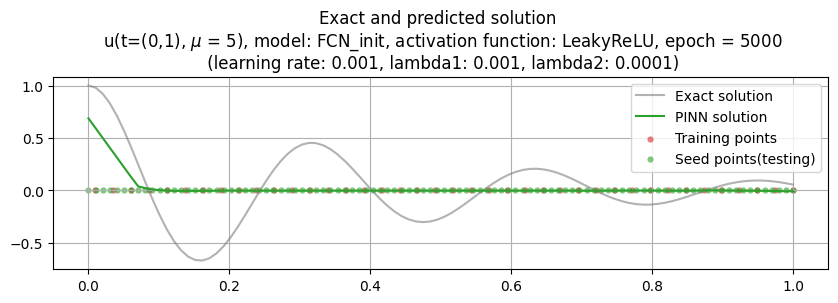

Decomposition of the loss terms: 
 loss(0.2945934236049652) = loss1(0.08398652821779251) + 0.001 * loss2(86.69658660888672) + 0.0001 * loss3(1239.1031494140625)


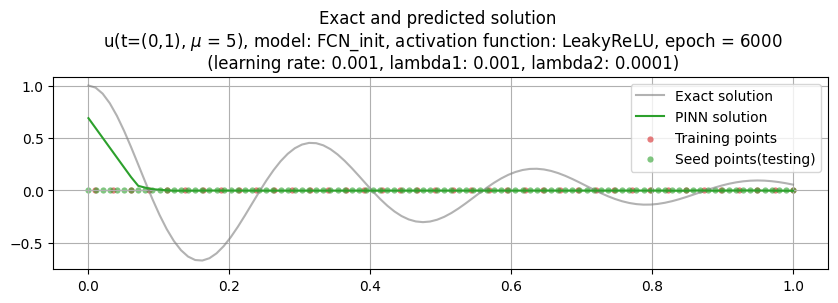

Decomposition of the loss terms: 
 loss(0.2988698482513428) = loss1(0.07227841764688492) + 0.001 * loss2(87.3243637084961) + 0.0001 * loss3(1392.6707763671875)


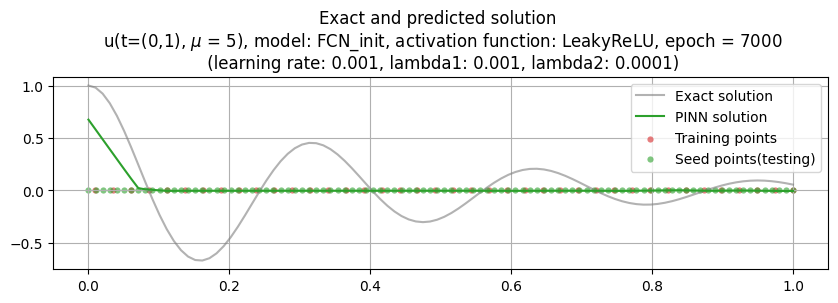

Decomposition of the loss terms: 
 loss(0.29471245408058167) = loss1(0.08532249182462692) + 0.001 * loss2(88.8666763305664) + 0.0001 * loss3(1205.232666015625)


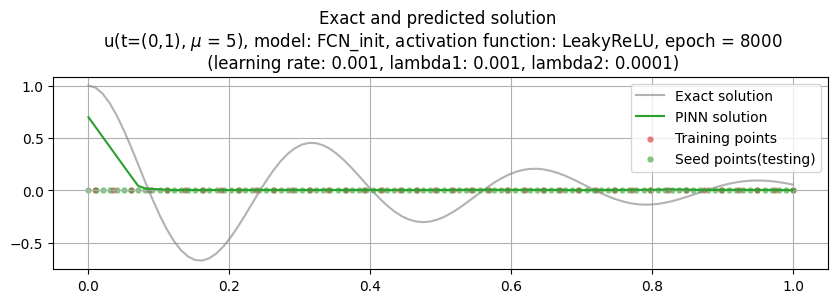

Decomposition of the loss terms: 
 loss(0.2950054407119751) = loss1(0.08100651949644089) + 0.001 * loss2(87.3086929321289) + 0.0001 * loss3(1266.902099609375)


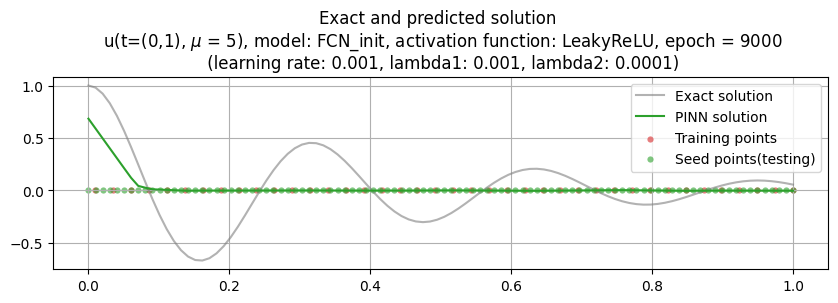

Decomposition of the loss terms: 
 loss(0.2955901026725769) = loss1(0.10197317600250244) + 0.001 * loss2(87.84552001953125) + 0.0001 * loss3(1057.714111328125)


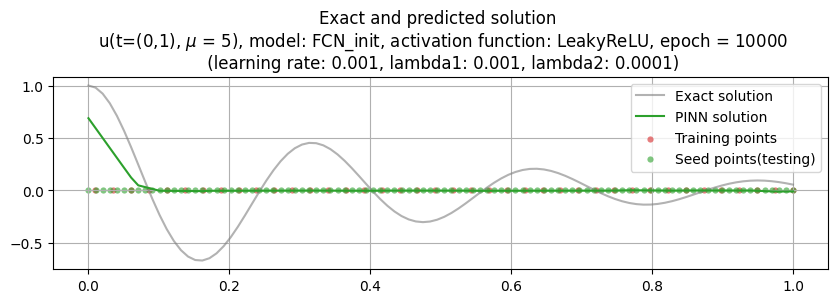

Training elapsed time (s): 83.74566960334778


In [80]:
optimizer_init = torch.optim.Adam(model_init.parameters(), lr= learning_rate)
epochs = 10001
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:

loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []

for i in range(epochs):
    optimizer_init.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= model_init(ic1_t_mu)
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = model_init(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    
    loss.backward()
    optimizer_init.step()
    
    
    if i%1000 == 0:
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted_init = model_init(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted_init[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: FCN_init, activation function: {activation_func}, epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")

# TASK 2:

## PINNS using 1 GPU

In [93]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import time

### Preparations for using the GPU

If a GPU is avaible, you could do the training using it. For that, you should send to the GPU all tensors are needed for the training. 

In [94]:
# To get only the name of the device:
torch.cuda.get_device_name(0)

'NVIDIA RTX A5000'

In [95]:
# Or for more information:
! nvidia-smi

Fri Jan 12 09:28:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000                On | 00000000:06:00.0 Off |                  Off |
| 30%   27C    P8               21W / 230W|    738MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [96]:
# To get the number of GPUs available:
torch.cuda.device_count()

1

In [97]:
# Save in a variable the device cuda(Linux and Windows), mps(Apple) or cpu, you will use for training:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [98]:
# or in a short way:
device_short_way = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_short_way

device(type='cuda', index=0)

You can know the current selected GPU using:

In [99]:
torch.cuda.current_device()

0

In case that you want to know the device a specific tensor is located:

In [100]:
#print(f"Device tensor is stored on: {t_boundary.device}") 

### Training using the GPU

In [101]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, w0**2            # Este mu NO se utiliza!!!!!
learning_rate_gpu =  1e-3         # learning rate
lambda1_gpu, lambda2_gpu = 1e-3, 1e-4 # loss term hyperparameters
epochs_gpu = 20001

In [102]:
point_resolution_gpu = 40
# Initial condition 1:
ic1_t_mu_gpu = torch.stack([torch.zeros(point_resolution_gpu).requires_grad_(True).to(device), torch.linspace(1,10, point_resolution_gpu).requires_grad_(True).to(device)],-1)
ic1_scope_gpu = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True).to(device)
print(f"Device tensor is stored on: {ic1_scope_gpu.device}") 
# Initial condition 1:
ic2_t_mu_gpu = torch.stack([torch.zeros(point_resolution_gpu).requires_grad_(True).to(device), torch.linspace(1,10, point_resolution_gpu).requires_grad_(True).to(device)], -1)
ic2_scope_gpu = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True).to(device)
print(f"Device tensor is stored on: {ic2_scope_gpu.device}") 

# Physical domain:
physic_in_t_mu_gpu = [torch.linspace(1e-2,1, point_resolution_gpu).requires_grad_(True).to(device), torch.linspace(1,10, point_resolution_gpu).requires_grad_(True).to(device)] # Mejora: se puede utilizar torch.rand
physic_domain_t_mu_gpu = torch.stack(torch.meshgrid(*physic_in_t_mu_gpu, indexing='ij'), -1).view(-1, 2).requires_grad_(True).to(device)
print(f"Device tensor is stored on: {physic_domain_t_mu_gpu.device}") 

# Test points:
point_resolution_test_gpu = 100
test_in_t_mu_gpu = [torch.linspace(0,1,point_resolution_test_gpu).to(device), torch.linspace(1,10,point_resolution_test_gpu).to(device) ]
test_domain_t_mu_gpu = torch.stack(torch.meshgrid(*test_in_t_mu_gpu, indexing='ij'), -1).view(-1, 2).to(device)
print(f"Device tensor is stored on: {test_domain_t_mu_gpu.device}") 


Device tensor is stored on: cuda:0
Device tensor is stored on: cuda:0
Device tensor is stored on: cuda:0
Device tensor is stored on: cuda:0


In [103]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u
### Definition of the Fully Connected Neural Network Class:
# Ben Moseley:
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Definition of the Fully Connected Neural Network Class
# Ben Moseley and added ACTIVATION FUNCTION and INITIALIZATION

class FCN_init(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation = "Tanh"):#, initialization = "Xavier"):
        super().__init__()
        activation_functions = nn.ModuleDict([
                                            ["Tanh", nn.Tanh()],
                                            ["ReLU", nn.ReLU()],
                                            ["LeakyReLU", nn.LeakyReLU()],
                                            ["Sigmoid", nn.Sigmoid()],
                                            ["Softmax", nn.Softmax()],
                                            ])
      # initialization_type = nn.ModuleDict([
      #     ["Xavier", nn.init.xavier_normal_],
      #     ])
        #activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation_functions[activation]])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation_functions[activation]]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.weights_and_bias_initialization()
        #self.initialization = initialization
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

    def weights_and_bias_initialization(self):
        for module_with_layers in self.modules():
            if isinstance(module_with_layers, nn.Linear):
                #initialization_type(module_with_layers.weight)
                nn.init.xavier_uniform_(module_with_layers.weight)
                #nn.init.constant_(module_with_layers.bias, 0)
                #nn.init.kaiming_uniform_(module_with_layers.weight)
                nn.init.constant_(module_with_layers.bias, 0)

class FCN_1(nn.Module):   # inherent from nn.Module
    "Defines a standard fully-connected network in PyTorch"
    # Initialization of the neural network layers in __init__:
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()                                      
        
        # INPUT Linear function: 1x1 --> 32x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        
        # INPUT Non-linearity (activation function): 32x1-->32x1
        self.tangh = nn.Tanh()
        
        # OUTPUT Linear function: 32x1 --> 1x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    
    def forward(self, input):
        # INPUT Linear function:
        hidden = self.fc_in(input)

        # HIDDEN Non-linearity
        hidden = self.tangh(hidden)

        # OUTPUT Linear function
        output = self.fc_out(hidden)
        
        return output

In [104]:
activation_func = "Tanh"
model_init_gpu = FCN_init(2,1,64,4, activation= activation_func)
model_init_gpu.to(device)

test_mu_gpu = 5
test_in_t_constant_mu_gpu = torch.stack([torch.linspace(0,1,point_resolution_test_gpu), test_mu_gpu*torch.ones(point_resolution_test_gpu)], -1).view(-1,2).to(device)
test_predicted_init_gpu = model_init_gpu(test_in_t_constant_mu_gpu)

optimiser_gpu = torch.optim.Adam(model_init_gpu.parameters(), lr= learning_rate_gpu)

epochs_gpu = 2001
start_gpu = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:
loss_ic1_history_gpu = []
loss_ic2_history_gpu = []
loss_differential_equation_history_gpu = []

Decomposition of the loss terms: 
 loss(1.4181662797927856) = loss1(0.6916042566299438) + 0.001 * loss2(0.005961898248642683) + 0.0001 * loss3(7265.560546875)


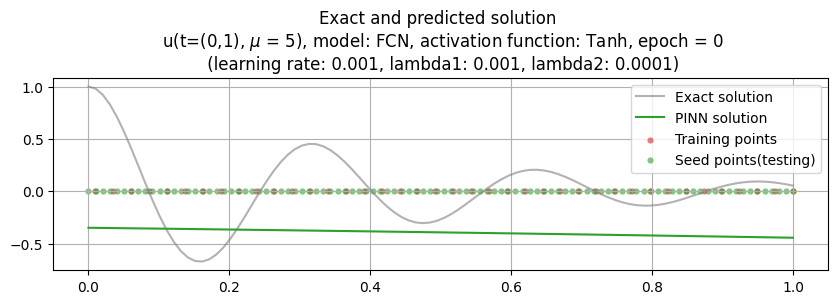

Saved the checkpoint corresponding to epoch: 0
Decomposition of the loss terms: 
 loss(0.061252642422914505) = loss1(0.006315743084996939) + 0.001 * loss2(0.08611173182725906) + 0.0001 * loss3(548.5078735351562)


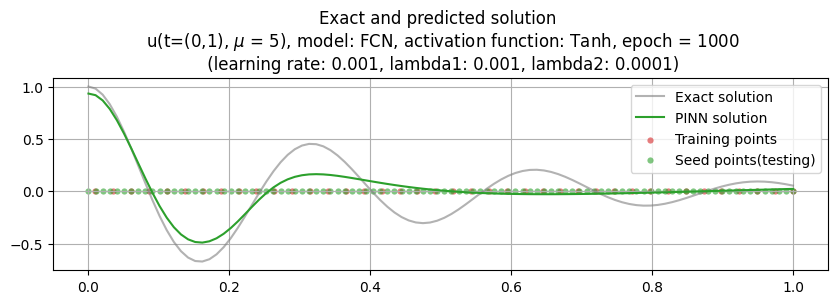

Saved the checkpoint corresponding to epoch: 1000
Decomposition of the loss terms: 
 loss(0.028854867443442345) = loss1(0.0019290924537926912) + 0.001 * loss2(0.03203515335917473) + 0.0001 * loss3(268.9374084472656)


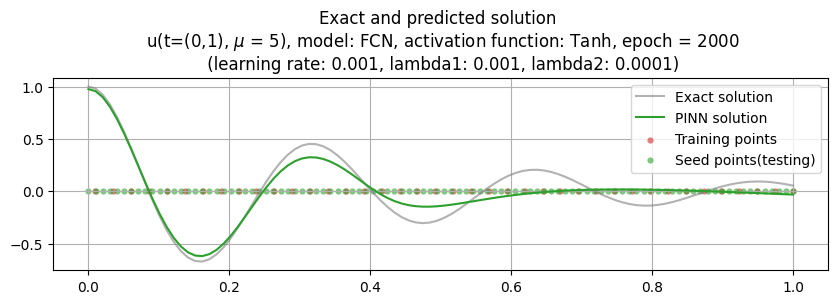

Saved the checkpoint corresponding to epoch: 2000
Training elapsed time (s): 1069.5303287506104


In [105]:
for i in range(epochs_gpu):
    optimiser_gpu.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted_gpu= model_init_gpu(ic1_t_mu_gpu)
    loss_ic1_gpu = torch.mean((ic1_predicted_gpu - ic1_scope_gpu)**2)
    loss_ic1_history_gpu.append(loss_ic1_gpu.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial_gpu = torch.autograd.grad(outputs = ic1_predicted_gpu, inputs = ic1_t_mu_gpu, grad_outputs= torch.ones_like(ic1_predicted_gpu), create_graph= True)[0]
    ic2_du_dt_gpu, ic2_du_dmu_gpu = du_dtdmu_initial_gpu[:, 0:1], du_dtdmu_initial_gpu[:,1:2]
    loss_ic2_gpu = torch.mean((ic2_du_dt_gpu- ic2_scope_gpu)**2)
    loss_ic2_history_gpu.append(loss_ic2_gpu.item())

    # compute physic loss:
    physic_domain_predicted_gpu = model_init_gpu(physic_domain_t_mu_gpu)
    physic_domain_du_dtdmu_gpu = torch.autograd.grad(outputs = physic_domain_predicted_gpu, inputs = physic_domain_t_mu_gpu, grad_outputs= torch.ones_like(physic_domain_predicted_gpu), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu_gpu = torch.autograd.grad(outputs = physic_domain_du_dtdmu_gpu[:,0:1], inputs = physic_domain_t_mu_gpu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu_gpu[:,0:1]), create_graph= True)[0]
    loss_differential_equation_gpu = torch.mean( (physic_domain_d2u_d2t_d2mu_gpu[:,0:1] + physic_domain_t_mu_gpu[:,1:2] * physic_domain_du_dtdmu_gpu[:,0:1] + k * physic_domain_predicted_gpu )**2)
    loss_differential_equation_history_gpu.append(loss_differential_equation_gpu.item())
    
    loss_gpu = loss_ic1_gpu + lambda1_gpu * loss_ic2_gpu + lambda2_gpu * loss_differential_equation_gpu
    
    loss_gpu.backward()
    optimiser_gpu.step()
    
    
    if i%1000 == 0:
        print(f'Decomposition of the loss terms: \n loss({loss_gpu}) = loss1({loss_ic1_gpu}) + {lambda1_gpu} * loss2({loss_ic2_gpu}) + {lambda2_gpu} * loss3({loss_differential_equation_gpu})')
        
        test_predicted_gpu = model_init_gpu(test_in_t_constant_mu_gpu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu_gpu[0].cpu().detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu_gpu[0].cpu().detach().numpy(), 
                test_predicted_gpu[:,0].cpu().detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu_gpu[0].cpu().detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu_gpu[0]).cpu().detach().numpy(), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu_gpu[0].cpu().detach().numpy(), 
                    torch.zeros_like(test_in_t_mu_gpu[0]).cpu().detach().numpy(), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu_gpu}), model: FCN, activation function: Tanh, epoch = {i} \n (learning rate: {learning_rate_gpu}, lambda1: {lambda1_gpu}, lambda2: {lambda2_gpu})")
        plt.grid()
        plt.legend()
        plt.show()
        torch.save({
                    "epoch": i,
                    "model_state_dict": model_init_gpu.state_dict(),
                    "optimiser_state_dict": optimiser_gpu.state_dict(),
                    "loss": loss_gpu,
                   },                    
                    f"{learning_rate}_{i}_gpu.pth")
        print(f"Saved the checkpoint corresponding to epoch: {i}")
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")